<a href="https://colab.research.google.com/github/EdvardasDlugauskas/VT-atvir-duomen-analiz-/blob/master/vilniustransportOpenDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing all libraries**

In [0]:
from os import listdir, path

import numpy as np
import pandas as pd

import torch
from torch import nn, optim, autograd, FloatTensor, LongTensor, manual_seed, randperm
import torch.nn.functional as F

from sklearn import model_selection, preprocessing

# **Importing data from csv files (pd.read_csv)**

add csv files which names is shown in this section

Need to have a `VTDeepLearn/data/` folder with CSV data files in your Google Drive (get them from here: [Mega link](https://mega.nz/file/fRxDmYgQ#vOPfSo0OJc51QpK8aTKYuBWZJMp89oszOoCE2m1b50s)).

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATA_FOLDER_PATH = "/content/drive/My Drive/VTDeepLearn/data"
file_names = sorted(listdir(DATA_FOLDER_PATH))[:100]
dataframes = [pd.read_csv(path.join(DATA_FOLDER_PATH, file)) for file in file_names]
all_data = pd.concat(dataframes).reset_index(drop=True)
all_data = all_data.drop(columns=['Number'])

print(file_names)
all_data.head()

['2016-04-25.csv', '2016-04-26.csv', '2016-04-27.csv', '2016-04-28.csv', '2016-04-29.csv', '2016-04-30.csv', '2016-05-01.csv', '2016-05-02.csv', '2016-05-03.csv', '2016-05-04.csv', '2016-05-05.csv', '2016-05-06.csv', '2016-05-07.csv', '2016-05-08.csv', '2016-05-09.csv', '2016-05-10.csv', '2016-05-11.csv', '2016-05-12.csv', '2016-05-13.csv', '2016-05-14.csv', '2016-05-15.csv', '2016-05-16.csv', '2016-05-17.csv', '2016-05-18.csv', '2016-05-19.csv', '2016-05-20.csv', '2016-05-21.csv', '2016-05-22.csv', '2016-05-23.csv', '2016-05-24.csv', '2016-05-25.csv', '2016-05-26.csv', '2016-05-27.csv', '2016-05-28.csv', '2016-05-29.csv', '2016-05-30.csv', '2016-05-31.csv', '2016-06-01.csv', '2016-06-02.csv', '2016-06-03.csv', '2016-06-04.csv', '2016-06-05.csv', '2016-06-06.csv', '2016-06-07.csv', '2016-06-08.csv', '2016-06-09.csv', '2016-06-10.csv', '2016-06-11.csv', '2016-06-12.csv', '2016-06-13.csv', '2016-06-14.csv', '2016-06-15.csv', '2016-06-16.csv', '2016-06-17.csv', '2016-06-18.csv', '2016-06-

,TransportType,StartStop,EndStop,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,IsHoliday
0,BUS,„Sparta“,Naujininkai,328,331,344,347,False
1,BUS,Naujininkai,Dariaus ir Girėno st.,346,351,361,364,False
2,BUS,„Sparta“,Stotis,367,367,385,384,False
3,BUS,„Sparta“,Dariaus ir Girėno st.,387,388,404,403,False
4,BUS,Prūsų st.,Felikso Vaitkaus st.,415,415,434,434,False


## Format data

Turn False/True to 0/1

Turn stop names into integers

Normalize time minute values

Turn transport type into integers

In [0]:
unique_stop_names = pd.Series(pd.concat([all_data['StartStop'], all_data['EndStop']]).unique()).reset_index().set_index(0).to_dict()['index']
all_data[['StartStop', 'EndStop']] = all_data[['StartStop', 'EndStop']].replace(unique_stop_names)

normalize_max = all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival']].max().max()
all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival']] = all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival']] / normalize_max;

max_cat = max(unique_stop_names.values())
all_data['TransportType'] = all_data['TransportType'].replace({"BUS": max_cat + 1, "EXP_BUS": max_cat + 2, "TROL": max_cat + 3})
all_data['IsHoliday'] = all_data['IsHoliday'].replace({False: max_cat + 4, True: max_cat + 5})
max_cat = max_cat + 5;


In [0]:
all_data.head()

,TransportType,StartStop,EndStop,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,IsHoliday
0,646,0,1,0.197234,0.199038,0.206855,0.208659,649
1,646,1,268,0.208058,0.211064,0.217078,0.218882,649
2,646,0,6,0.220686,0.220686,0.231509,0.230908,649
3,646,0,268,0.232712,0.233313,0.242934,0.242333,649
4,646,2,3,0.249549,0.249549,0.260974,0.260974,649


In [0]:
cont_test_data = all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival']].to_numpy()
cat_test_data = all_data[['TransportType', 'StartStop', 'EndStop', 'IsHoliday']].to_numpy()
y_test_data = all_data['ActualArrival'].to_numpy().reshape(-1, 1)

test_sets = model_selection.train_test_split(cont_test_data, cat_test_data, y_test_data, test_size=0.1)
train_cont, test_cont = map(lambda x: autograd.Variable(FloatTensor(x), requires_grad=True).cuda(), test_sets[0:2])
train_cat, test_cat = map(lambda x: autograd.Variable(LongTensor(x)).cuda(), test_sets[2:4])
train_y, test_y = map(lambda x: autograd.Variable(FloatTensor(x)).cuda(), test_sets[4:6])

In [0]:
class Net(nn.Module):

  def __init__(self):

    super().__init__()

    embed_dict_size = max_cat + 1

    embed_dim = 5

    # Embedding layer
    self.emb_layer = nn.Embedding(embed_dict_size, embed_dim)

    # Linear Layers
    self.first_layer = nn.Linear(embed_dim * 4 + 3, 30);
    self.second_layer = nn.Linear(30, 20);
    self.output_layer = nn.Linear(20, 1);

    self.generic_relu = nn.LeakyReLU();

  def forward(self, cont_data, cat_data):
    cat_embedded = self.emb_layer(cat_data)

    x = self.first_layer(torch.cat([cat_embedded.view(cat_embedded.shape[0], -1), cont_data], dim=1))
    x = self.generic_relu(x)
    
    x = self.second_layer(x)
    x = self.generic_relu(x)

    x = self.output_layer(x)

    return x

In [0]:
manual_seed(3)

net = Net()

use_cuda = True
if use_cuda and torch.cuda.is_available():
    net.cuda()



In [33]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
loss_func = nn.MSELoss()

data_len = train_cont.size()[0]
test_len = test_cont.size()[0]
batch_size = data_len // 100

val_loss_history = []
train_loss_history = []

for epoch in range(1, 5_000):
    net.train()

    permutation = randperm(data_len)

    epoch_losses = []
    for batch_i in range(0, data_len//2, batch_size):
        indices = permutation[batch_i:batch_i+batch_size]
        cont_batch_x = train_cont[indices]
        cat_batch_x = train_cat[indices]
        batch_y = train_y[indices]

        outputs = net(cont_batch_x, cat_batch_x)
        loss = loss_func(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    train_loss_history.append(np.mean(epoch_losses))

    net.eval()
    y_hat = net(test_cont, test_cat) 

    val_loss = loss_func(y_hat, test_y).item()
    val_loss_history.append(val_loss)

    if not epoch % 10:
        print(f"Epoch: {epoch}, loss: {val_loss}")

    


print('Finished Training')

Epoch: 10, loss: 4.912649728794349e-06
Epoch: 20, loss: 4.912442364002345e-06
Epoch: 30, loss: 4.91176751893363e-06
Epoch: 40, loss: 4.911797987006139e-06
Epoch: 50, loss: 4.9109708015748765e-06
Epoch: 60, loss: 4.910118605039315e-06
Epoch: 70, loss: 4.9102900447905995e-06
Epoch: 80, loss: 4.909266863251105e-06
Epoch: 90, loss: 4.909121798846172e-06
Epoch: 100, loss: 4.909031304123346e-06
Epoch: 110, loss: 4.90799720864743e-06
Epoch: 120, loss: 4.907783477392513e-06
Epoch: 130, loss: 4.907660240860423e-06
Epoch: 140, loss: 4.9073100854002405e-06
Epoch: 150, loss: 4.9064810809795745e-06
Epoch: 160, loss: 4.906444246444153e-06
Epoch: 170, loss: 4.905791683995631e-06
Epoch: 180, loss: 4.904944034933578e-06
Epoch: 190, loss: 4.90448337586713e-06
Epoch: 200, loss: 4.904198704025475e-06
Epoch: 210, loss: 4.903924491372891e-06
Epoch: 220, loss: 4.9031968956114724e-06
Epoch: 230, loss: 4.90299044031417e-06
Epoch: 240, loss: 4.902827186015202e-06
Epoch: 250, loss: 4.902022737951484e-06
Epoch: 2

## Save the model

In [0]:
import uuid

SAVE_PATH = "/content/drive/My Drive/VTDeepLearn/"

unique_filename = "model" + str(uuid.uuid4()) + ".pt";
torch.save(net.state_dict(), SAVE_PATH + unique_filename)

# Plot

In [0]:
from matplotlib import pyplot as plt

## Train loss vs test loss

([<matplotlib.lines.Line2D at 0x7f737c507128>],
 [<matplotlib.lines.Line2D at 0x7f737c507240>])

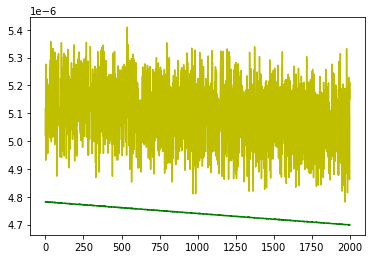

In [35]:
plt.plot(train_loss_history[-2000:], c="y"), plt.plot(val_loss_history[-2000:], c="g")

## Final model

In [0]:
y_hat = net(test_cont, test_cat)

(<matplotlib.collections.PathCollection at 0x7f737bf2c908>,
 <matplotlib.collections.PathCollection at 0x7f737bf2ccc0>)

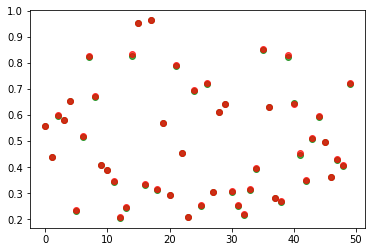

In [27]:
count = 50
plt.scatter(range(count),test_y.cpu().numpy()[:count], alpha=0.7, c='g'), plt.scatter(range(count), y_hat.detach().cpu().numpy()[:count], alpha=0.7, c='r')

# Resources & links

https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379

https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=RBCa4nG5wJAv

https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/
![alt text](https://yashuseth.files.wordpress.com/2018/07/model1.png)

Problem: model guessing the same number for all inputs (mean/baseline)

Solution: normalize input